# Задание
Даны участки телеметрии работы оборудования (9 датчиков/столбцов,
128 сек) соответствующие шести различным режимам. Каждый режим
работает 128 сек: Один режим – 128 секунд/строк
1.   Проанализировать данные, статистики, сделать EDA, визуально
посмотреть на разделимость режимов работы известными вам
методами.
2.   Использовать из sklearn'а
SelectKBest и выбрать по рангам наиболее значимые
столбцы/признаки/фичи
https://scikit-learn.org/stable/modules/generated/
sklearn.feature_selection.SelectKBest.html
3.  Предсказать режимы работы оборудования на тестовых данных
(X_test), посчитать точность/precision, полноту/recall, ROC-AUC
на y_test. Использовать 2–3 алгоритма, прокомментировать
результаты.
4.  Если результаты по любой из метрик ниже 0.88 на y_test –
добавить фичи, и превысить порог в 0.88.

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import BaggingClassifier

In [134]:
X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')
y_test = np.load('y_test.npy')
y_train = np.load('y_train.npy')

Объединим тестовые и тренировочные данные

In [135]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [136]:
y = np.repeat(y, np.repeat(np.array([128]), y.shape[0]), axis=0)
y.shape

(1318272, 6)

In [137]:
X = X.reshape(-1, 9)
X.shape

(1318272, 9)

Преобразуем целевую переменную из вектора

In [138]:
y_int = np.argmax(y, axis=1)
y_int.shape

(1318272,)

In [139]:
df = pd.DataFrame(X, columns=['0','1', '2', '3','4','5','6','7','8'])
df

,0,1,2,3,4,5,6,7,8
0,1.012817,-0.123217,0.102934,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859
1,1.022833,-0.126876,0.105687,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316
2,1.022028,-0.124004,0.102102,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250
3,1.017877,-0.124928,0.106553,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751
4,1.023680,-0.125767,0.102814,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553
...,...,...,...,...,...,...,...,...,...
1318267,0.908386,-0.423054,-0.092933,-0.061667,-0.175584,0.151117,0.148295,-0.015923,0.109040
1318268,0.898984,-0.392272,-0.063138,-0.070890,-0.145071,0.181814,0.143136,-0.024389,0.006547
1318269,0.918862,-0.351680,-0.072539,-0.050755,-0.104717,0.173271,0.095931,-0.021024,-0.051342
1318270,0.949475,-0.267526,-0.050975,-0.019807,-0.020764,0.195638,0.090708,-0.041893,-0.078877


In [140]:
df['target'] = y_int
df

,0,1,2,3,4,5,6,7,8,target
0,1.012817,-0.123217,0.102934,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859,4
1,1.022833,-0.126876,0.105687,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316,4
2,1.022028,-0.124004,0.102102,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250,4
3,1.017877,-0.124928,0.106553,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751,4
4,1.023680,-0.125767,0.102814,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553,4
...,...,...,...,...,...,...,...,...,...,...
1318267,0.908386,-0.423054,-0.092933,-0.061667,-0.175584,0.151117,0.148295,-0.015923,0.109040,1
1318268,0.898984,-0.392272,-0.063138,-0.070890,-0.145071,0.181814,0.143136,-0.024389,0.006547,1
1318269,0.918862,-0.351680,-0.072539,-0.050755,-0.104717,0.173271,0.095931,-0.021024,-0.051342,1
1318270,0.949475,-0.267526,-0.050975,-0.019807,-0.020764,0.195638,0.090708,-0.041893,-0.078877,1


In [141]:
#sensor_index = 0
#sensor_data = X_train[:, :, sensor_index]

#df_sensor = pd.DataFrame(sensor_data, columns=[f'Time_{i}' for i in range(sensor_data.shape[1])])

#for i in range(y_train.shape[1]):
    #df_sensor[f'Mode_{i+1}'] = y_train[:, i]

### EDA

In [142]:
df.head()

,0,1,2,3,4,5,6,7,8,target
0,1.012817,-0.123217,0.102934,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859,4
1,1.022833,-0.126876,0.105687,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316,4
2,1.022028,-0.124004,0.102102,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250,4
3,1.017877,-0.124928,0.106553,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751,4
4,1.023680,-0.125767,0.102814,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553,4


In [143]:
y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

Преобразуем 'y' в другой формат

In [144]:
def reformat_array(arr):
    return np.where(arr == 1)[0][0]

y = np.array([reformat_array(arr) for arr in y])


Посмотрим на распределение по всем режимам

<Axes: xlabel='target', ylabel='count'>

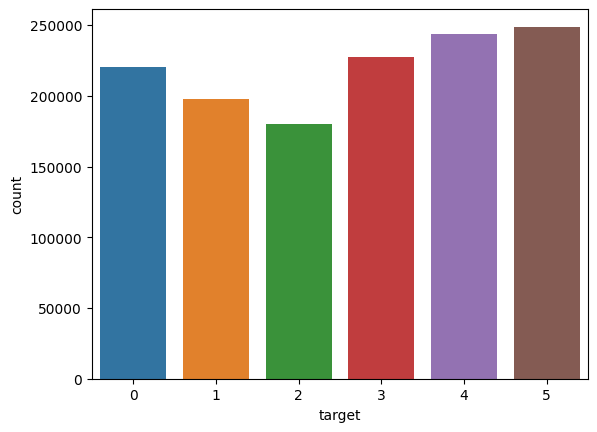

In [145]:
sns.countplot(df, x="target")

Посмотрим на корелляцию датчиков

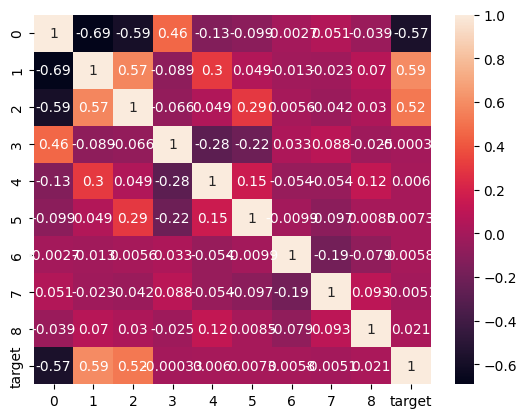

In [146]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Выберем по рангам наиболее значимые столбцы

In [147]:
X = pd.DataFrame(data=X)
y = pd.DataFrame(data=y)

In [148]:
X = df.iloc[:, :9].values
y = df['target'].values.astype(int)

In [149]:
X = SelectKBest(k=9).fit_transform(X, y)

### Обучение моделей

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)

### DecisionTreeClassifier

In [151]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [152]:
y_pred = model.predict(X_test)

In [153]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
y_pred = model.predict_proba(X_test)
print(f'AUC ROC: {roc_auc_score(y_test, y_pred, average="micro", multi_class="ovr")}')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))

AUC ROC: 0.9646689356279173
Точность: 0.9358045264204797
Полнота: 0.9355953395410914


### RandomForestClassifier

In [154]:
model = RandomForestClassifier(random_state=42,min_samples_leaf=3,min_samples_split=2,n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [155]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
y_pred = model.predict_proba(X_test)
print(f'AUC ROC: {roc_auc_score(y_test, y_pred, average="micro", multi_class="ovr")}')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))

AUC ROC: 0.9981040723090252
Точность: 0.9528768237210534
Полнота: 0.9517385805497213


### KNN

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [157]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
y_pred = model.predict_proba(X_test)
print(f'AUC ROC: {roc_auc_score(y_test, y_pred, average="micro", multi_class="ovr")}')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))

AUC ROC: 0.9885505075585562
Точность: 0.907973099325921
Полнота: 0.9023354036628284


Во всех алгоритмах метрики показали результаты > 0,88, лучшие результаты у RandomForestClassifier